# Resampling Parameters

## Initialization (`__init__`)

### Positional Arguments

* **coordinates** : array_like (n_samples,) or (n_dimensions, n_samples)
  
  The coordinates of each data sample.  1-dimensional data may be
  supplied as a 1-dimensional array (n_samples,).  For more than one
  dimension, the coordinates for each dimension should be supplied as
  separate rows in the input array.


* **data** : array_like (n_samples,) or (n_sets, n_samples)

  The data values at each coordinate.  Multiple sets that share the
  same coordinates may be fit concurrently by supplying `data` as a
  2-dimensional array (n_sets, n_samples)


### Optional Arguments

* **error** : array_like (n_samples,)

  The associated $1\sigma$ `data` errors.

* **mask** : array_like of bool (n_samples,)

  A Boolean array where `True` indicates a valid sample, and `False`
  indicates the associated `data` sample should be ignored.
  **NOTE:** any NaN values in `data` will automatically be masked.

* **window** : float or array_like (n_dimensions,)

  The radius of the fitting window across each dimension.  May be
  supplied as a scalar to be applied over all dimensions or an
  array giving the window width for each dimension. A sample will be
  included in a fit if it satisfies:

  $$\sum_{i=1}^{n}{\left(\frac{a_i - x_i}{\omega_i}\right)^2}\leq1$$

  where $a_i$ is the sample coordinate in dimension $i$, $x$ is the 
  coordinate at which we   want to generate a fit, and $\omega$ is 
  `window`.  **NOTE**: if window is not provided, the resampler will
  attempt to guess the window width based on the median sample spacing.
  This is not recommended if you have data in different units for
  different dimensions.
  
* **order** : int or array_like of int (n_dimensions,)

  The polynomial order to fit.  A single integer order may be
  provided for all dimensions, or an integer array can be used to
  specify different orders for each dimension.  **NOTE**: We will
  refer to an order as being "symmetric" when it is same across
  all dimensions for the remainder of this document.
  
* **mode** : str

  There are currently 3 different algorithms available to check
  whether a the samples within `window` of a resampling point
  are distributed in a manner where a polynomial fit of `order`
  should be attempted.  The three algorithms are:
  
    - "*edges*": The most robust (default) algorithm requiring
        there are enough unique samples to the "right" and "left"
        of each resampling point over each dimensions. For example,
        for an `order=2` fit in 1-dimension where `o` is a
        resampling point and `x` is a sample:
            fail: x x o x x x x (requires 3 samples to the left)
            pass: x x x o x x x 
        **NOTE**: This is classed as the most robust as it hopefully
        ensures that no singular matrices are encountered during
        fitting, and also allows for a bounded solution.
            
    - "*extrapolate*": Fairly robust algorithm requiring that
        there are enough unique samples over each dimension to
        perform a fit of the required polynomial order.  For
        example, for an `order=2` fit in 1-dimension:
            fail: x x o | x o x | o x x (requires 3 unique samples)
            pass: x x x o | x x o x | x o x x | o x x x

        **NOTE**: There is the possibility for fitting to explode
        when unbounded.  Under certain circumstances, singular
        matrices may occur.
            
    - "*counts*": Requires that there are merely enough samples
        ($n$) within the full hyperspace window to satisfy
        $n\ge\prod_{i=1}^{n}\left({o_i + 1}\right)$ where $o_i$
        is the order in dimension $i$.  This is not a recommended
        mode as singular matrix errors may occur.  The benefit is
        that it is fast.
  
  
* **fix_order** : bool

  If the `mode` algorithm detects a failure, there are two options:
  The first is to abort fitting a resampling point and replace it
  with `cval` using `fix_order=True`, and the second is to reduce
  the order such that `mode` allows fitting to continue using
  `fix_order=False`.  Lowering `order` is only possible if `order`
  is symmetric.
  
* **negthresh** : float

  Initial filtering on the input data, masking out all data (over
  each dataset) such that
  
  $$\forall{z},\, z>-negthresh * \sigma_{z}$$
  
  where $z$ is the data to be fitted and $\sigma_{z}$ is the
  standard deviation of the data.
  
* **robust** : float

  Initial filtering on the input data, masking out all data
  (over each dataset) such that
  
  $$\forall{z},\, \frac{\left|z - \tilde{z}\right|}{MAD}\le robust$$
  
  where $z$ is the data to be fitted, $\tilde{z}$ is the median of
  the data and $MAD$ is the Median Absolute Deviation of the data
  given by $MAD = 1.482 * \tilde{\left|z - \tilde{z}\right|}$

## `__call__`

### Positional Arguments

* **args** :

  The variable length `args` parameter is used to specify the output
  coordinates at which we wish to resample.  This may be done in several
  different ways:
  
    - float or tuple of floats : Resample at a single coordinate location.
        For 1-dimension a single float value should be supplied.  For
        multiple dimensions, a value should be provided for each dimension.
        The resulting output will be a float value.
        
    - array_like or tuple or array_like : Resamples onto a regular grid.
        Each argument corresponds to the output grid ordinates for a
        particular dimension.  For example, for 3-dimensional resampling,
        the user should supply 2 arrays of sizes J, K, and L for the
        x, y, and z dimensions respectively.  The resulting output will
        be a cube of shape (L, K, J).
        
    - array_like (n_dimensions, n_points) : Resamples onto an irregular
        grid where dimensions are ordered along the zeroth axis.  The
        resulting output will be an array of shape (n_points,).

### Optional Arguments

* **smoothing** : float or array_like of float (n_dimensions,)

  Samples may be weighted by Euclidean distance from the resampling point
  using the weighting function:
  
  $$weight = exp{\left(-\sum_{i=1}^{n}\frac{(a_i - x_i)^2}{\omega_i^2\alpha_i}\right)}$$
    
  where for dimension $i$, $a$ is the sample coordinate, $x$ is the resampling
  coordinate, $\omega$ is the window and $\alpha$ is the `smoothing`.  This is
  applied in addition to the error weighting.  Once again, a scalar maybe
  supplied over all dimensions or an array (n_dimensions,) may be used to
  supply different values to each dimension.

* **relative_smooth** : bool

  If `False`, changes the equation above to
  
  $$weight = exp{\left(-\sum_{i=1}^{n}\frac{(a_i - x_i)^2}{\alpha_i^2}\right)}$$ 


* **fit_threshold** : float

  After a fit, set `fit_threshold` to a positive nonzero value to
  reject any fits such that
  
  $$\forall{d_{fit}},\, \left|d_{fit}-\bar{d_{samples}}\right| < threshold * \sigma_{d_{samples}}$$
  
  Values that could not be fit are replaced by the weighted mean
  of the samples used to fit each point.
  
* **cval** : float

  During fitting, any fit that does not meet the initialization `mode`
  requirement will be set to this value.  This will be NaN by default.
  
* **edge_threshold** : float or array_like of float (n_dimensions,)

  If `0 < edge_threshold < 1` then edges of the fit will be masked out
  according to `edge_algorithm`.  Values close to zero will result in
  a high degree of edge clipping, while values close to 1 ckip edges to
  a lesser extent.  The clipping threshold is a fraction of `window`.
  
* **edge_algorithm** : str

  Describes how to clip edges if `edge_threshold` is non-zero.  The
  available algorithms are:
  
  - 'com_distance' (default): If the samples used to fit a resampling
    point deviate from the resampling point location by more than
    this amount, it will be clipped.
  - 'com_feature': If the flattened 1-dimensional distribution of
    samples center-of-mass deviates from the resampling point location
    in any dimension, it will be clipped.
  - 'range': Over each dimension, check that the distribution of
    points is greater than `edge_threshold` to the "left" and "right"
    of the resampling point.
    
* **error_weighting** : bool
  If True (default), weight polynomial fitting by the `error` values
  of each sample.

* **get_error** : bool

  If `True` returns the error which is given as the weighted RMS of
  the samples used for each resampling point.
  
* **get_counts** : bool

  If `True` returns the number of samples used to fit each resampling
  point.
  
* **jobs** : int

  Specifies the maximum number of concurrently running jobs.  An
  attempt will be made to parallel process using a thread-pool if
  available, but will otherwise revert to the "loky" backend.
  Values of 0 or 1 will result in serial processing.  A negative
  value sets jobs to `n_cpus + 1 + jobs` such that -1 would use
  all cpus, and -2 would use all but one cpu.  Supplying any
  integer value here will override `client`.
  
* **client** : dict or dask.distributed.Client

  If not None, use dask for processing jobs in parallel.  An
  existing client may be passed in or a dictionary containing
  keyword arguments to pass to a local client and workers during
  initialization.  An empty dictionary ({}) will result in a
  default LocalCluster client.  Please see `dask.distributed.Client`
  for further details.

## Return Values

* **fit, \[error\], \[counts\]**

  - `fit`: The resampled data supplied as a numpy array of float64
    (\[n_sets,\] n_points,).
  - `error`: The error of the fit as a numpy array of float64
    (\[n_sets,\] n_points,).
    `get_error=True` must be set to return `error`.
  - `counts` : The number of samples use to fit each resampling point as a
    numpy array of int64 (\[n_sets,\] n_points,).


The following example creates fit, error, and counts:

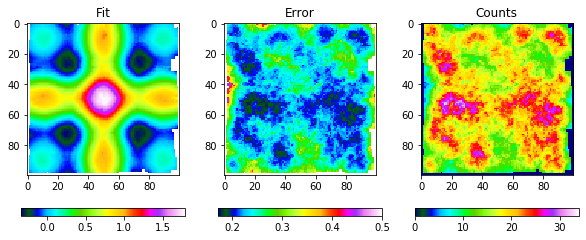

In [1]:
from sofia_redux.toolkit.resampling.resample import Resample
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Create 2-dimensional test data
random = np.random.RandomState(41)
x = (random.rand(1000) - 0.5) * 2 * np.pi
y = (random.rand(1000) - 0.5) * 2 * np.pi
z = np.sinc(x) + np.sinc(y)

# Create a Resample object
resampler = Resample([x, y], z)

# Resample to a regular grid
xo = np.linspace(-np.pi, np.pi, 100)
yo = xo.copy()
fit, error, counts = resampler(
    xo, yo, get_error=True, get_counts=True, jobs=-1)

# Plot the result
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(fit, cmap='gist_ncar')
plt.colorbar(orientation='horizontal')
plt.title("Fit")
plt.subplot(1, 3, 2)
plt.imshow(error, cmap='gist_ncar')
plt.colorbar(orientation='horizontal')
plt.title("Error")
plt.subplot(1, 3, 3)
plt.imshow(counts, cmap='gist_ncar')
plt.colorbar(orientation='horizontal')
_ = plt.title("Counts")